# Study the middle layers of GNN tracking model
This notebook is a part of the GNN tracking model series. In this notebook, we will study the middle layers of the GNN tracking model to show it's ability to classify correct and incorrect trackings based on the node features as we perform more layers of message passing. For simplicity, we use only one of the timelaps movies and we choose 40 frames of it to plot. We directly read the node features from previously saved assignment graphs.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
import matplotlib.transforms as mtransforms
from bread import vis
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bread.algo import tracking
from bread.data import *
from sklearn.metrics import confusion_matrix
from pathlib import Path
from collections import defaultdict
import tqdm
from glob import glob
import sys
import os.path
from bread.algo.tracking import AssignmentDataset, GNNTracker, AssignmentClassifier, GraphLoader, accuracy_assignment, f1_assignment
import torch

## Load the model

In [ ]:
model_folder = 'tracking/results/scaled_images/results_fourier_10_and_f10_locality_False/_100KB_/2023-12-19_12:47:30'
model_dir = Path(model_folder)
algo = 'hungarian'

with open(model_dir / 'hyperparams.json') as file:
    hparams = json.load(file)

net = AssignmentClassifier(
    GNNTracker,
    module__num_node_attr=hparams['num_node_attr'],
    module__num_edge_attr=hparams['num_edge_attr'],
    module__dropout_rate=hparams['dropout_rate'],
    module__encoder_hidden_channels=hparams['encoder_hidden_channels'],
    module__encoder_num_layers=hparams['encoder_num_layers'],
    module__conv_hidden_channels=hparams['conv_hidden_channels'],
    module__conv_num_layers=hparams['conv_num_layers'],
    module__num_classes=1,
    iterator_train=GraphLoader,
    iterator_valid=GraphLoader,
    criterion=torch.nn.BCEWithLogitsLoss,
).initialize()
net.load_params(model_dir / 'params.pt')
net.module_.train(False)

GNNTracker(
  (node_encoder): MLP(60, 120, 120, 120, 120)
  (edge_encoder): MLP(10, 120, 120, 120, 120)
  (layers): ModuleList(
    (0-2): 3 x DeepGCNLayer(block=res+)
  )
  (out): MLP(120, 60, 30, 1)
)

## Load the data (from assignment graphs)

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.decomposition import tsne
import random
import plotly.express as px
from MulticoreTSNE import MulticoreTSNE as TSNE
import plotly.express as px

In [ ]:
# bread/data/generated/test_tracking/ass_graphs_original/colony003_segmentation__assgraph__dt_004__001_to_005.pt
assignment_graph_dir = Path(
    "tracking/generated_data/scaled_images/ass_graphs_fourier_10_f10_locality_False")
# for colony000_segmentation__assgraph__dt_001__000_to_001.pt (example)
colony_name = "colony000"
time_diff = 2
first_frame = 0
number_of_frames = 40
next_frame = first_frame + time_diff
seg = SegmentationFile.from_h5(
    '../../data/segmentations/colony000_segmentation.h5').get_segmentation("FOV0")

ass_graph_path = assignment_graph_dir / \
    f'{colony_name}_segmentation__assgraph__dt_{time_diff:03d}__{first_frame:03d}_to_{next_frame:03d}.pt'
print(ass_graph_path)
graph_files = []
for i in range(first_frame, first_frame+number_of_frames):
    next_frame = i+time_diff
    ass_graph_path = assignment_graph_dir / \
        f'{colony_name}_segmentation__assgraph__dt_{time_diff:03d}__{i:03d}_to_{next_frame:03d}.pt'
    graph_files.append(ass_graph_path)

/mlodata1/hokarami/fari/tracking/generated_data/scaled_images/ass_graphs_fourier_10_f10_locality_False/colony000_segmentation__assgraph__dt_002__000_to_002.pt


In [ ]:
mid_layers_accumulated_last = []
mid_layers_accumulated_first = []
mid_layers_accumulated_1 = []
inputs_accumulated = []
labels_accumulated = []
age_gaps_accumulated = []
cell_ids1_accumulated = []
cell_ids2_accumulated = []
ages1_accumulated = []
ages2_accumulated = []
time_id_accumulated = []

for file in tqdm.tqdm(graph_files, desc='testing'):
    idt1_pattern = r'__(\d{3})_to'
    idt2_pattern = r'_to_(\d{3})'
    dt_pattern = r'_dt_(\d{3})'
    # data_name is from first underline to where we have "_segmentation"
    data_name_pattern = r'(\w+)_segmentation'
    idt1 = int(re.findall(idt1_pattern, str(file))[0])
    idt2 = int(re.findall(idt2_pattern, str(file))[0])
    dt = int(re.findall(dt_pattern, str(file))[0])
    data_name = re.findall(data_name_pattern, str(file))[0]

    torch.cuda.empty_cache()

    # read graph from .pt file
    graph = torch.load(file)

    nodes = graph.cell_ids
    cell_ids1 = seg.cell_ids(idt1)
    cell_ids2 = seg.cell_ids(idt2)
    birth1 = [idt1 for x in cell_ids1] - seg.birth_times(idt1)
    birth2 = [idt2 for x in cell_ids2] - seg.birth_times(idt2)
    time_id = [idt1 for x in nodes]

    # calculate age gap for cells in the graph
    age_gaps = [
        abs(birth1[cell_ids1.index(id1)] - birth2[cell_ids2.index(id2)])
        for id1, id2 in nodes
    ]
    ages1 = [birth1[cell_ids1.index(id1)] for id1, id2 in nodes]
    ages2 = [birth2[cell_ids2.index(id2)] for id1, id2 in nodes]
    # This is not the same as above. this should be same size as yhat and nodes
    cell_ids1 = [id1 for id1, id2 in nodes]
    cell_ids2 = [id2 for id1, id2 in nodes]

    yhat, mid_layer = net.predict_assignment(graph, return_middle_values=True)
    yhat = yhat.flatten()
    y = graph.y.squeeze().cpu().numpy()

    # Append mid-layer and labels to accumulated arrays
    mid_layers_accumulated_last.append(mid_layer[-1].cpu().numpy())
    mid_layers_accumulated_first.append(mid_layer[0].cpu().numpy())
    mid_layers_accumulated_1.append(mid_layer[1].cpu().numpy())
    inputs_accumulated.append(graph.x.cpu().numpy())

    age_gaps_accumulated.append(age_gaps)
    labels_accumulated.append(y)
    cell_ids1_accumulated.append(cell_ids1)
    cell_ids2_accumulated.append(cell_ids2)
    ages1_accumulated.append(ages1)
    ages2_accumulated.append(ages2)
    time_id_accumulated.append(time_id)

combined_mid_layers_first = np.vstack(mid_layers_accumulated_first)
combined_mid_layers_last = np.vstack(mid_layers_accumulated_last)
combined_mid_layers_1 = np.vstack(mid_layers_accumulated_1)
combined_inputs = np.vstack(inputs_accumulated)
combined_age_gaps = np.hstack(age_gaps_accumulated)
combined_labels = np.hstack(labels_accumulated)
combined_cell_ids1 = np.hstack(cell_ids1_accumulated)
combined_cell_ids2 = np.hstack(cell_ids2_accumulated)
combined_ages1 = np.hstack(ages1_accumulated)
combined_ages2 = np.hstack(ages2_accumulated)
combined_time_id = np.hstack(time_id_accumulated)

testing: 100%|██████████| 60/60 [12:33<00:00, 12.55s/it]


In [51]:
# Save combined_mid_layers as a .npy file
if not os.path.exists('saved'):
    os.makedirs('saved')
np.save('saved/combined_mid_layers_first.npy', combined_mid_layers_first)
np.save('saved/combined_mid_layers_last.npy', combined_mid_layers_last)
np.save('saved/combined_mid_layers_1.npy', combined_mid_layers_1)
np.save('saved/combined_inputs.npy', combined_inputs)

# Save other combined lists as .npy files if needed
np.save('saved/combined_age_gaps.npy', combined_age_gaps)
np.save('saved/combined_labels.npy', combined_labels)
np.save('saved/combined_cell_ids1.npy', combined_cell_ids1)
np.save('saved/combined_cell_ids2.npy', combined_cell_ids2)
np.save('saved/combined_ages1.npy', combined_ages1)
np.save('saved/combined_ages2.npy', combined_ages2)
np.save('saved/combined_time_id.npy', combined_time_id)

In [ ]:
# read the saved .npy files
combined_mid_layers_first = np.load('saved/combined_mid_layers_first.npy')
combined_mid_layers_last = np.load('saved/combined_mid_layers_last.npy')
combined_mid_layers_1 = np.load('saved/combined_mid_layers_1.npy')
combined_inputs = np.load('saved/combined_inputs.npy')
combined_age_gaps = np.load('saved/combined_age_gaps.npy')
combined_labels = np.load('saved/combined_labels.npy')
combined_cell_ids1 = np.load('saved/combined_cell_ids1.npy')
combined_cell_ids2 = np.load('saved/combined_cell_ids2.npy')
combined_ages1 = np.load('saved/combined_ages1.npy')
combined_ages2 = np.load('saved/combined_ages2.npy')
combined_time_id = np.load('saved/combined_time_id.npy')

## Plot tsne for inputs vs after first layer of MP, and in the last layer of MP

In [5]:
pca_input_mid_layers_comparison = pd.read_csv('saved/pca_input_mid_df.csv')

In [8]:
# import pca
from sklearn.decomposition import PCA

In [9]:
# apply pca to combined_mid_layers
pca = PCA(n_components=2)
pca_inputs = pca.fit_transform(combined_inputs)
pca_mid_layers_first = pca.fit_transform(combined_mid_layers_first)
pca_mid_layers_last = pca.fit_transform(combined_mid_layers_last)
pca_mid_layers_1 = pca.fit_transform(combined_mid_layers_1)

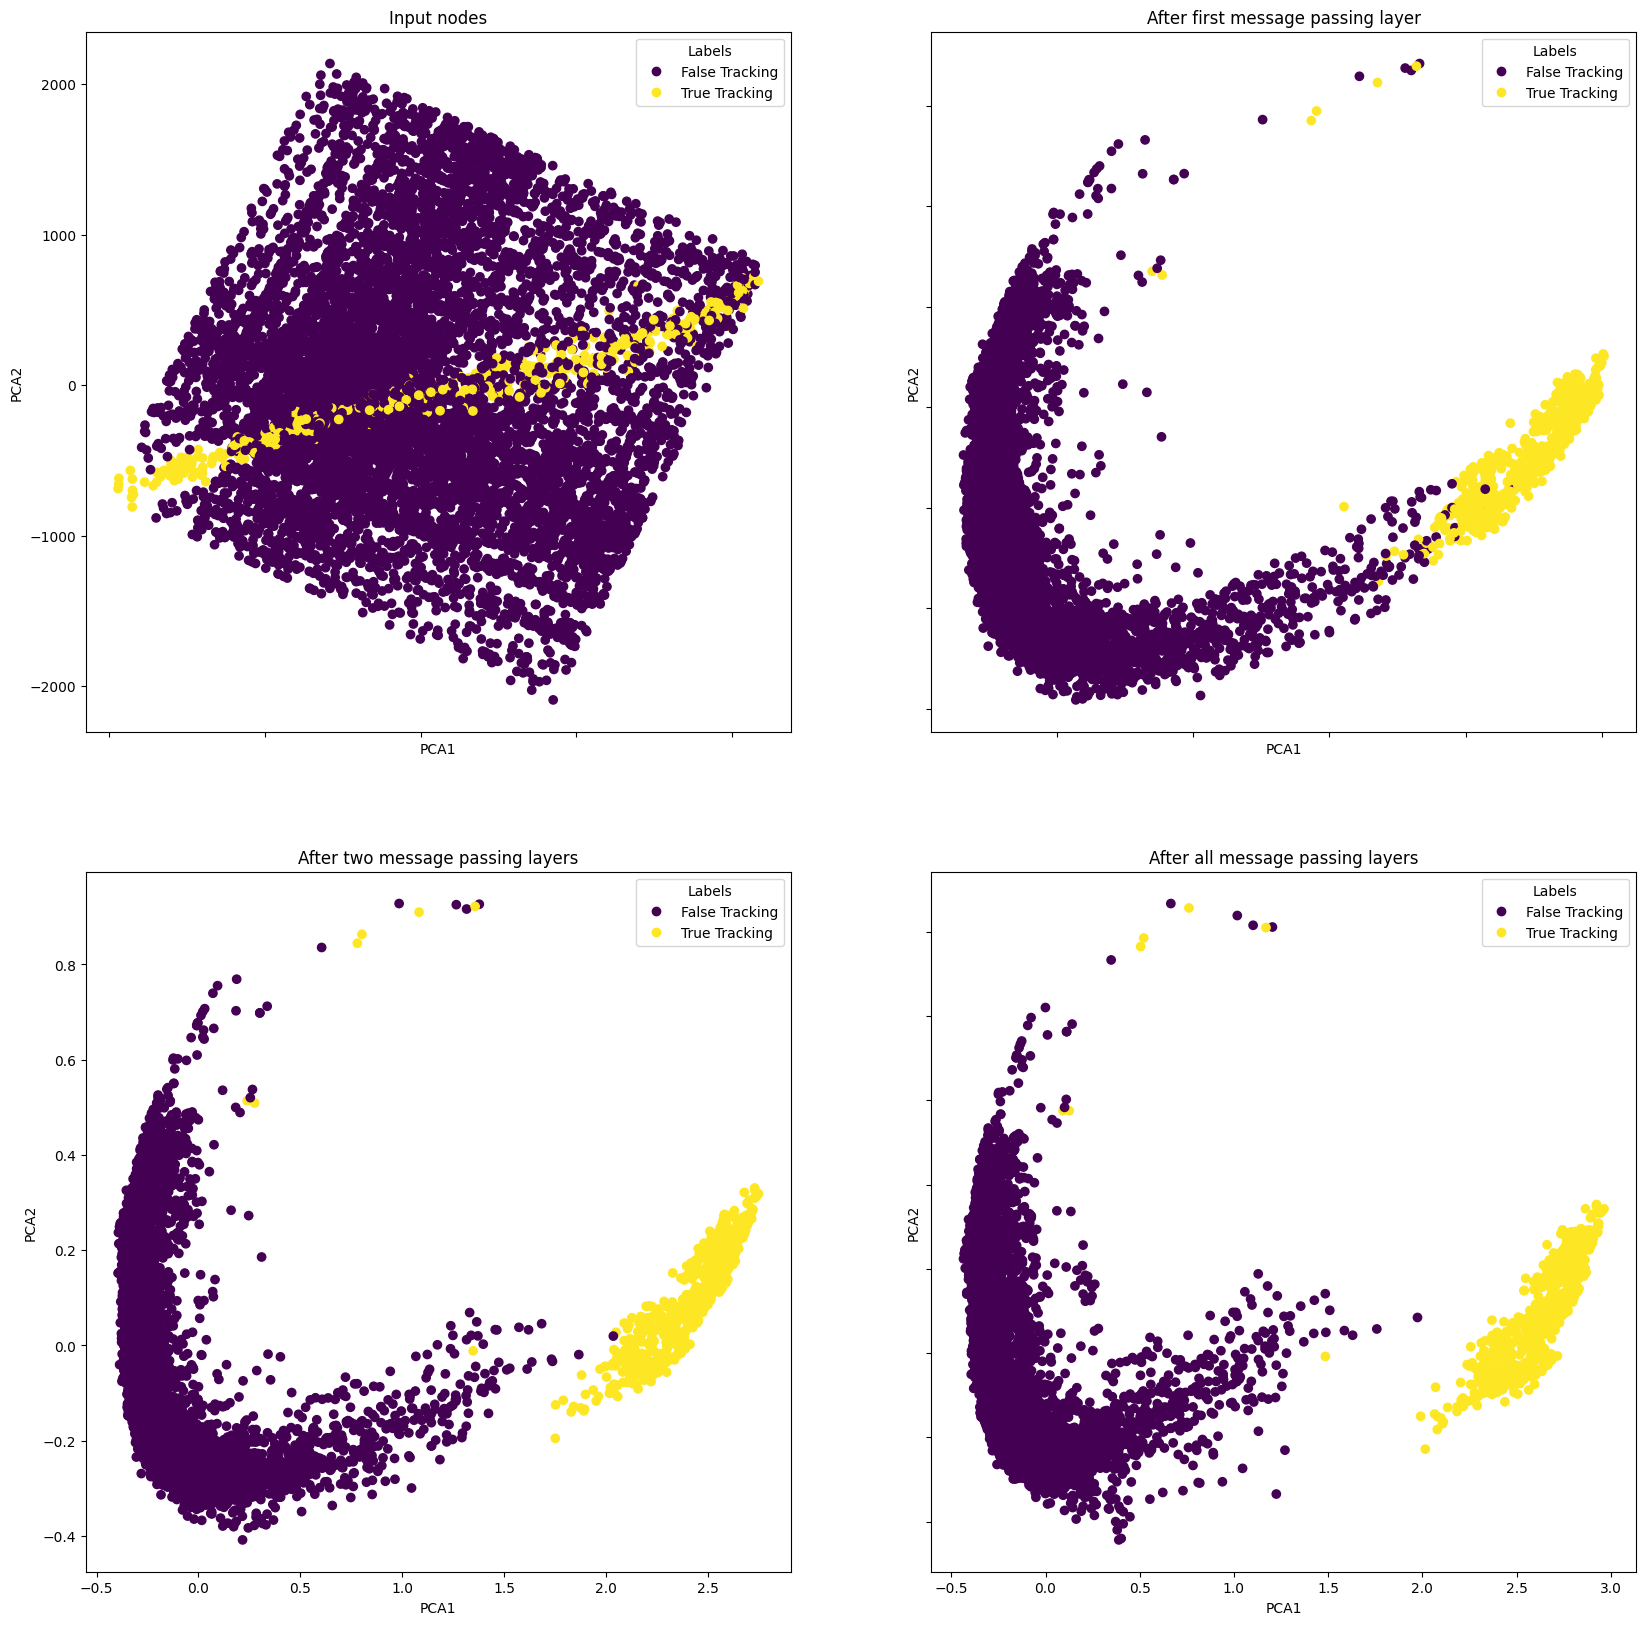

In [ ]:
import matplotlib.pyplot as plt

# Your existing plotting code
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Scatter plots capturing the return values
scatter1 = ax[0, 0].scatter(
    pca_inputs[:, 0], pca_inputs[:, 1], c=combined_labels)
ax[0, 0].set_title('Input nodes')

scatter2 = ax[0, 1].scatter(
    pca_mid_layers_first[:, 0], pca_mid_layers_first[:, 1], c=combined_labels)
ax[0, 1].set_title('After first message passing layer')

scatter3 = ax[1, 0].scatter(pca_mid_layers_1[:, 0],
                            pca_mid_layers_1[:, 1], c=combined_labels)
ax[1, 0].set_title('After two message passing layers')

scatter4 = ax[1, 1].scatter(
    pca_mid_layers_last[:, 0], pca_mid_layers_last[:, 1], c=combined_labels)
ax[1, 1].set_title('After all message passing layers')

# Add labels to axes
for axes in ax.flatten():
    axes.label_outer()
    axes.set_xlabel('PCA1')
    axes.set_ylabel('PCA2')

# Assuming 'label_names' is a list of your labels corresponding to 'combined_labels'
# For example: label_names = ['Label1', 'Label2', ...]
# Update this with actual labels
label_names = ['False Tracking', 'True Tracking']

# Create legends
legend1 = ax[0, 0].legend(*scatter1.legend_elements(),
                          title="Labels", loc="upper right")
legend2 = ax[0, 1].legend(*scatter2.legend_elements(),
                          title="Labels", loc="upper right")
legend3 = ax[1, 0].legend(*scatter3.legend_elements(),
                          title="Labels", loc="upper right")
legend4 = ax[1, 1].legend(*scatter4.legend_elements(),
                          title="Labels", loc="upper right")

# Update legends with label names
for leg in [legend1, legend2, legend3, legend4]:
    for i, text in enumerate(leg.get_texts()):
        text.set_text(label_names[i])

plt.show()

In [ ]:
plt.savefig('saved/compare_middle_layers_pca.pdf')

<Figure size 640x480 with 0 Axes>

In [11]:
# same thing but with t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_inputs = tsne.fit_transform(combined_inputs)
tsne_mid_layers_first = tsne.fit_transform(combined_mid_layers_first)
tsne_mid_layers_last = tsne.fit_transform(combined_mid_layers_last)
tsne_mid_layers_1 = tsne.fit_transform(combined_mid_layers_1)

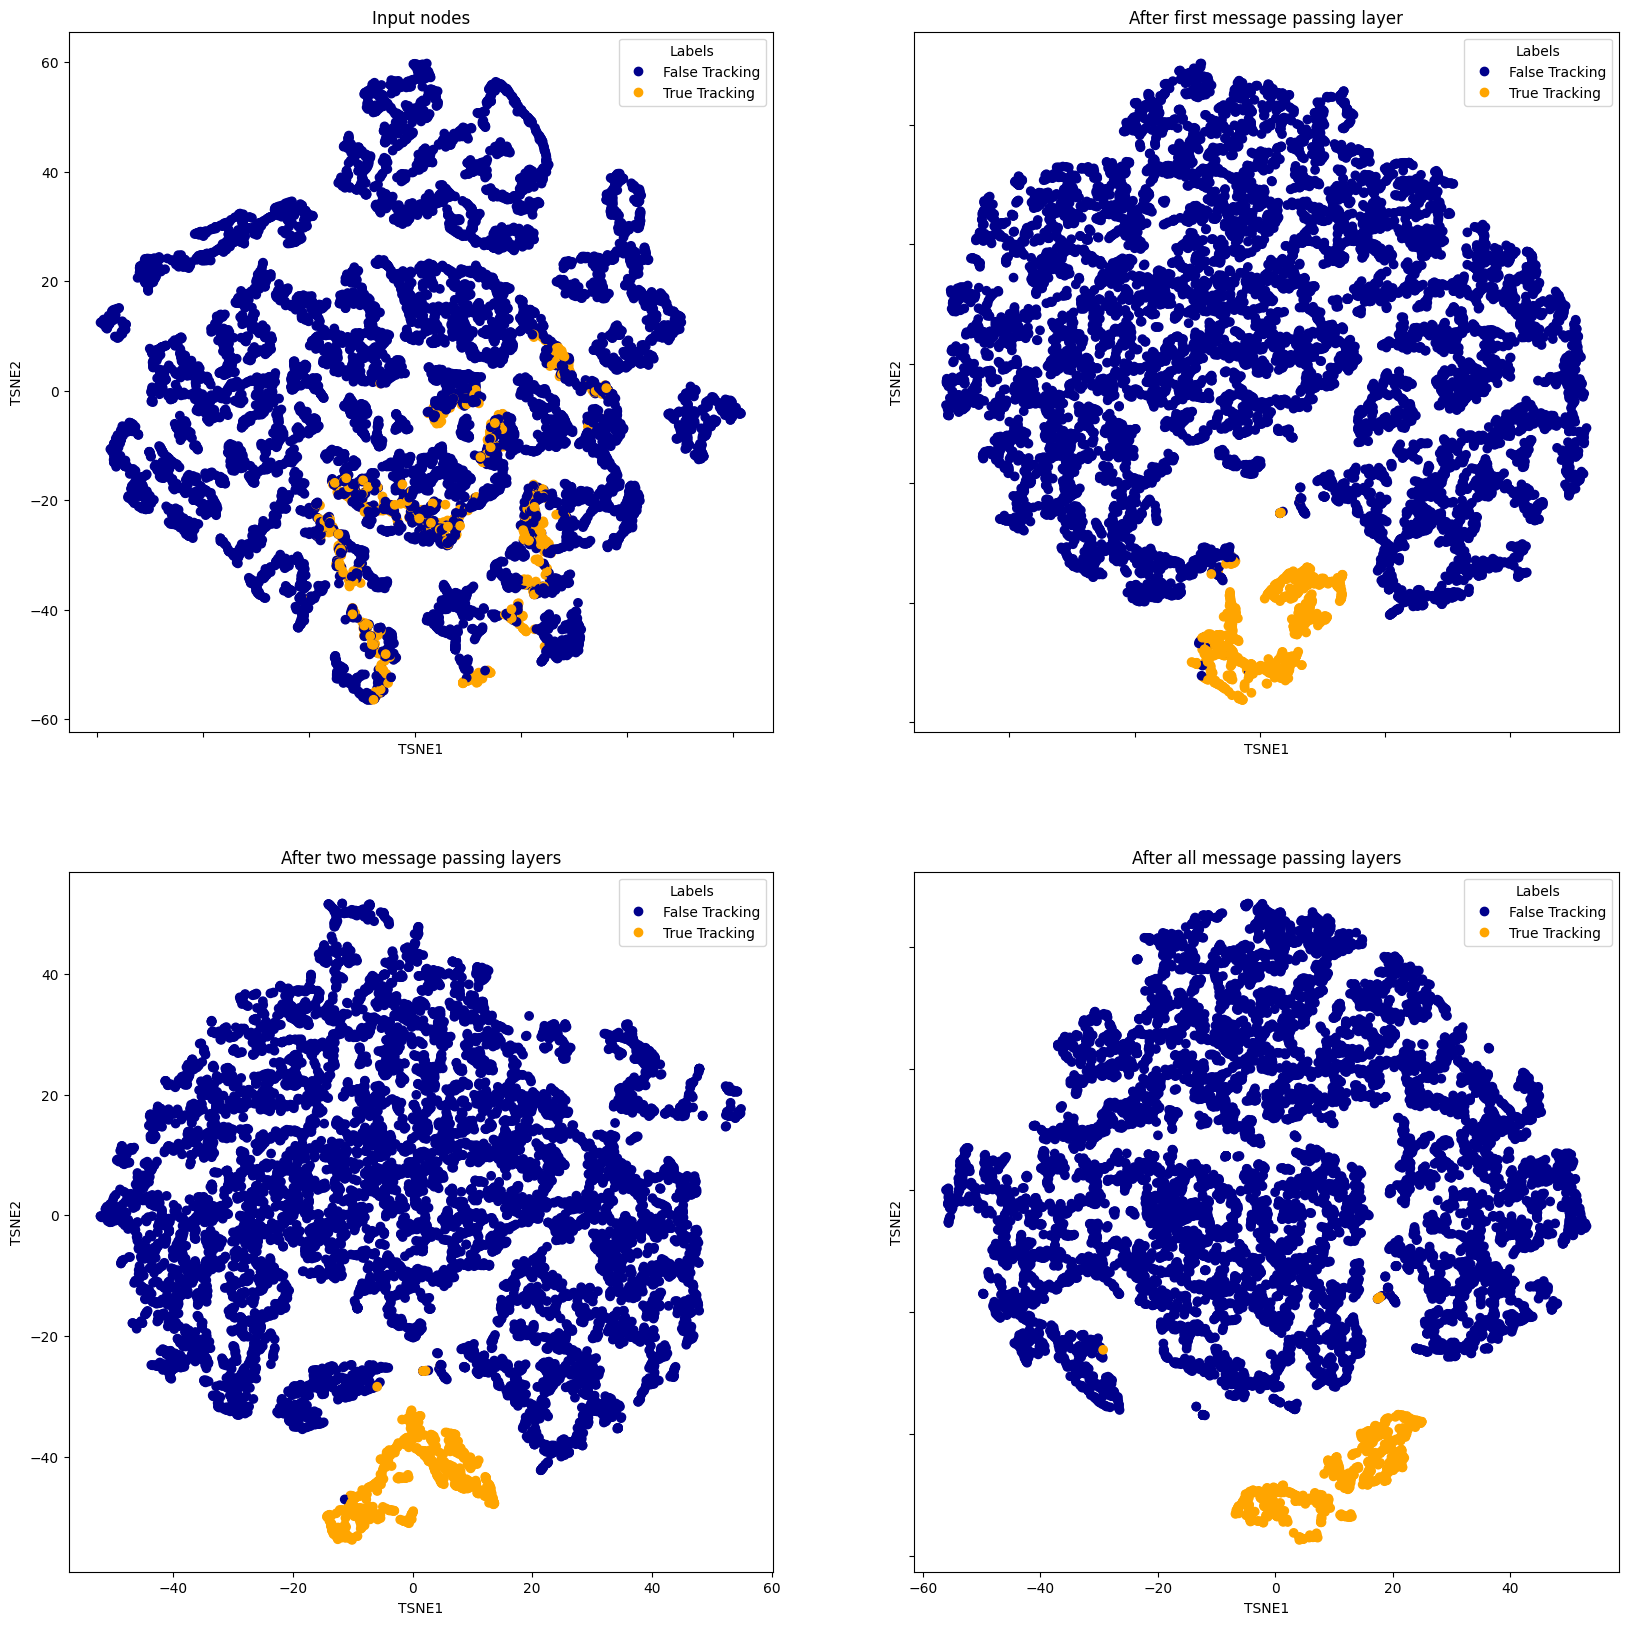

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap
label_colors = ['darkblue', 'orange']  # Assuming you have two labels
cmap = mcolors.ListedColormap(label_colors)

# Your existing plotting code
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# Scatter plots capturing the return values with custom colors
scatter1 = ax[0, 0].scatter(
    tsne_inputs[:, 0], tsne_inputs[:, 1], c=combined_labels, cmap=cmap)
ax[0, 0].set_title('Input nodes')

scatter2 = ax[0, 1].scatter(tsne_mid_layers_first[:, 0],
                            tsne_mid_layers_first[:, 1], c=combined_labels, cmap=cmap)
ax[0, 1].set_title('After first message passing layer')

scatter3 = ax[1, 0].scatter(
    tsne_mid_layers_1[:, 0], tsne_mid_layers_1[:, 1], c=combined_labels, cmap=cmap)
ax[1, 0].set_title('After two message passing layers')

scatter4 = ax[1, 1].scatter(tsne_mid_layers_last[:, 0],
                            tsne_mid_layers_last[:, 1], c=combined_labels, cmap=cmap)
ax[1, 1].set_title('After all message passing layers')

# Add labels to axes
for axes in ax.flatten():
    axes.label_outer()
    axes.set_xlabel('TSNE1')
    axes.set_ylabel('TSNE2')

# Assuming 'label_names' is a list of your labels corresponding to 'combined_labels'
# Update this with actual labels
label_names = ['False Tracking', 'True Tracking']

# Create legends
legend1 = ax[0, 0].legend(*scatter1.legend_elements(),
                          title="Labels", loc="upper right")
legend2 = ax[0, 1].legend(*scatter2.legend_elements(),
                          title="Labels", loc="upper right")
legend3 = ax[1, 0].legend(*scatter3.legend_elements(),
                          title="Labels", loc="upper right")
legend4 = ax[1, 1].legend(*scatter4.legend_elements(),
                          title="Labels", loc="upper right")

# Update legends with label names
for leg in [legend1, legend2, legend3, legend4]:
    for i, text in enumerate(leg.get_texts()):
        text.set_text(label_names[i])

plt.show()

In [ ]:
plt.savefig('saved/compare_middle_layers_tsne.pdf')

<Figure size 640x480 with 0 Axes>